In [ ]:
%load_ext tensorboard

In [ ]:
input("REMEMBER YO CHANGE CONFIGURATION FILE \n FINE_TUNING = False ")

REMEMBER YO CHANGE CONFIGURATION FILE 
 FINE_TUNING = False ok


'ok'

# Importaciones

In [ ]:
import configuration as config

In [ ]:
import seaborn as sns
from os import listdir
import pandas as pd
import numpy as np
import mimetypes

from PIL import Image
# import the necessary packages
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
import datetime

# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [ ]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
  '''
  Plotea la matriz de confusión
  '''
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
  ax.set_title(title, fontsize=16)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_ylabel('Etiqueta Real', fontsize=12)
  ax.set_xlabel('Etiqueta Predicha', fontsize=12)

In [ ]:
def bb_intersection_over_union(boxA, boxB):
  '''
  Función para calcular la Interseción sobre la unión entre un par de cuadros
  '''	
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
  return iou

In [ ]:
URL_DRIVE = config.URL_DRIVE
IMAGE_PATH = config.IMAGE_PATH
log_dir = config.LOG_DIR
plot_path = config.PLOT_PATH

output_path = config.OUTPUT_PATH
test_size = config.TEST_SIZE_SPLIT

loss_label = config.LOSS_LABEL
loss_boundingbox = config.LOSS_BOUNDINGBOX
loss_weights = config.LOSS_WEIGHT

init_lr = config.INIT_LR
model_metrics = config.MODEL_METRICS
num_epochs = config.NUM_EPOCHS
batch_size = config.BATCH_SIZE

print_summary = config.PRINT_SUMMARY


In [ ]:
# Seleccionamos el dataset que tiene los datos
df = pd.read_csv(f"{URL_DRIVE}df_breve.csv")
df.drop("Unnamed: 0", axis = 1, inplace=True)
df_completo = pd.read_csv(f"{URL_DRIVE}df.csv")
df_completo.drop("Unnamed: 0", axis = 1, inplace=True)

df.head(5)

,image,Starting x-coordinate,Starting y-coordinate,Ending x-coordinate,Ending y-coordinate,class label
0,00001063.jpg,235,212,306,255,engine
1,00000259.jpg,363,411,1343,705,wing
2,00000901.jpg,578,86,967,359,fus
3,00001190.jpg,487,218,995,289,wing
4,00001108.png,1,7,1056,298,fus


# Preparación

## Datos

In [ ]:
# Inicializamos la lista de datos, etiquetas y cuadros delimitadores
print("[INFO] Cargando el dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

for i in range(len(df)):
	
	j = df.iloc[i,:]
	# Escalamos el cuadro delimitador a las dimensiones de la imagen de entrada.
	image_url = IMAGE_PATH + j[0]
	image = cv2.imread(image_url)
	(h, w) = image.shape[:2]
	startX = float(j[1]) / w
	startY = float(j[2]) / h
	endX = float(j[3]) / w
	endY = float(j[4]) / h


	image = load_img(image_url, target_size=(224, 224))
	image = img_to_array(image)
  # Cargamos los datos a las listas inicializadas antes
	data.append(image)
	labels.append(j[5])
	bboxes.append((startX, startY, endX, endY))    
	imagePaths.append(image_url)

print("[INFO] Hecho!")

[INFO] Cargando el dataset...
[INFO] Hecho!


In [ ]:
# Convertimos las listas en arrays y escalamos la imagen entre [0,1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# one-hot encoding en las etiquetas
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
if len(lb.classes_) == 2:
	labels = to_categorical(labels)


## Modelo

In [ ]:

# Particionamos los datos en entrenamiento y validación 
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=test_size, random_state=42)
 
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# Vamos a guardar el nombre de los ficheros que vamos a usar en el conjunto de v
# validación

print("[INFO] saving testing image paths...")
f = open(f"{output_path}test_paths.txt", "w")
f.write("\n".join(testPaths))
f.close()

# Cargamos el modelo VGG con los pesos del entrenamiento en imagenet y sin las 
# últimas capas
vgg = VGG16(weights = "imagenet", include_top = False, 
            input_tensor = Input(shape=(224,224,3)))
# Congelamos los pesos de modo que no se "entrenen" durante el entrenamiento
vgg.trainable = False

if print_summary:
  vgg.summary()

[INFO] saving testing image paths...
58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Vamos a añadir más capas
flatten = vgg.output
flatten = Flatten()(flatten)

bboxHead = Dense(32, activation="relu")(flatten)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
 
softmaxHead = Dense(256, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)

#Juntamos todo: Modelo que acepta como input una imagen y que tiene como salida
# las etiquetas y los cuadros delimitadores
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

# Definir un diccionario para establecer las funciones de pérdida 
losses = {
	"class_label": loss_label,
	"bounding_box": loss_boundingbox,
}
# Diccionario para los pesos. Mismo para los dos
lossWeights = {
	"class_label": loss_weights,
	"bounding_box": loss_weights
}
# Compilamos el modelo
opt = Adam(lr=init_lr)#config.INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=model_metrics, loss_weights=lossWeights)

# Diccionario para nuestras salidas de entrenamiento
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# Diccionario para nuestras salidas de validación
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

if print_summary:
  print(model.summary())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenamiento

In [ ]:
# Entrenamiento
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data = (testImages, testTargets),
	batch_size = batch_size,
	epochs = num_epochs,
	verbose = 1,
	callbacks = [tensorboard_callback])

# Serializamos el modelo en disco
print("[INFO] Guardando detector...")
model.save(f"{output_path}detector.h5", save_format = "h5")
# Serializamos el binarizador de etiquetas en disco
print("[INFO] Guardando binarizador...")
f = open(f"{output_path}lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/25
14/14 [==============================] - 229s 16s/step - loss: 1.7116 - bounding_box_loss: 0.0526 - class_label_loss: 1.6591 - bounding_box_accuracy: 0.5047 - class_label_accuracy: 0.2382 - val_loss: 1.5034 - val_bounding_box_loss: 0.0400 - val_class_label_loss: 1.4634 - val_bounding_box_accuracy: 0.6321 - val_class_label_accuracy: 0.2642
Epoch 2/25
14/14 [==============================] - 214s 16s/step - loss: 1.3194 - bounding_box_loss: 0.0368 - class_label_loss: 1.2827 - bounding_box_accuracy: 0.6014 - class_label_accuracy: 0.4080 - val_loss: 1.4750 - val_bounding_box_loss: 0.0415 - val_class_label_loss: 1.4335 - val_bounding_box_accuracy: 0.5377 - val_class_label_accuracy: 0.2642
Epoch 3/25
14/14 [==============================] - 252s 18s/step - loss: 1.1437 - bounding_box_loss: 0.0329 - class_label_loss: 1.1109 - bounding_box_accuracy: 0.5849 - class_label_accuracy: 0.5165 - val_loss: 1.4666 - val_bounding_box_loss: 0.0389 - val_class_label_los

In [ ]:
#%tensorboard --logdir log_dir

# Resultados

## Accuracy y Pérdida

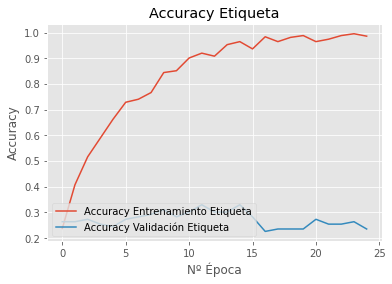

In [ ]:
# Graficamos la pérdida total, de la etiqueta y del cuadro delimitador
lossNames =  ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, num_epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# Iteramos para las diferentes pérdidas
for (i, l) in enumerate(lossNames):
	# Pérdida para entrenamiento y validación
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Nº Époco")
	ax[i].set_ylabel("Pérdida")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# Guardamos 
plt.tight_layout()
plotPath = os.path.sep.join([plot_path, "losses.png"])
plt.savefig(plotPath)
plt.close()

# Figura para accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="Accuracy Entrenamiento Etiqueta")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="Accuracy Validación Etiqueta")
plt.title("Accuracy Etiqueta")
plt.xlabel("Nº Época")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([plot_path, "accs.png"])
plt.savefig(plotPath)

## Matriz de Confusión

In [ ]:
# Vamos a obtener el resto de métricas 
args = {}
args["input"] = f"{output_path}test_paths.txt"
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

if "text/plain" == filetype:
	# Cargamos la ruta de cada imagen
	imagePaths = open(args["input"]).read().strip().split("\n")

L_imagepath = []
L_imagename = []
L_box = []
L_label = []
# Recorremos todas las imagenes
for imagePath in imagePaths:
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)
# Predicimos la etiqueta y el cuadro delimitador
  (boxPreds, labelPreds) = model.predict(image)
  (startX, startY, endX, endY) = boxPreds[0]

  # Guardamos la clase con mayor probabilidad
  i = np.argmax(labelPreds, axis=1)
  label = lb.classes_[i][0]
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]

  box = [int(startX * w),int(startY * h),int(endX * w),int(endY * h),]
  L_imagepath.append(imagePath)
  L_imagename.append(imagePath.split("/")[-1])
  L_box.append(box)
  L_label.append(label)


results = {"imagepath":L_imagepath,"image":L_imagename,"box":L_box,"class label":L_label}
results = pd.DataFrame(results)

In [ ]:
y_real = []
y_pred = []
for i in imagePaths:
  imagename = i.split("/")[-1]

  y_real.append(df[df["image"]==imagename]["class label"].values[0])

  y_pred.append(results[results["image"]==imagename]["class label"].values[0])

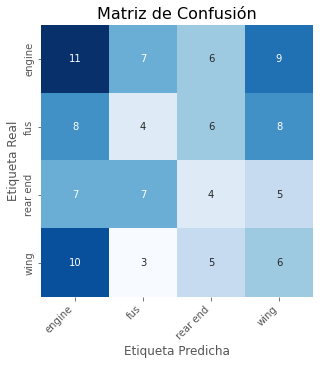

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_heatmap(y_real, y_pred, lb.classes_, ax, "Matriz de Confusión")

## Matriz de Confusión con IoU

In [ ]:
filtered = df_completo.copy()
filtered["box"] = filtered[["Starting x-coordinate","Starting y-coordinate","Ending x-coordinate","Ending y-coordinate"]].values.tolist()
filtered = filtered[["image", "box", "class label"]]


filtered = filtered.merge(results, how = "inner", on = "image", suffixes=('_true', '_pred'))
filtered["iou"] = pd.Series()
for i in range(len(filtered)):
  filtered.iloc[i,-1] = bb_intersection_over_union(filtered.iloc[i,1],filtered.iloc[i,4])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [ ]:
imagesnames = [i.split("/")[-1] for i in imagePaths]
imagesnames

df_iou_max = pd.DataFrame()
for i in imagesnames:
  otro = filtered[filtered["image"]==i].reset_index(drop=True)
  df_iou_max = pd.concat([df_iou_max,pd.DataFrame(otro.iloc[otro["iou"].idxmax()]).T])

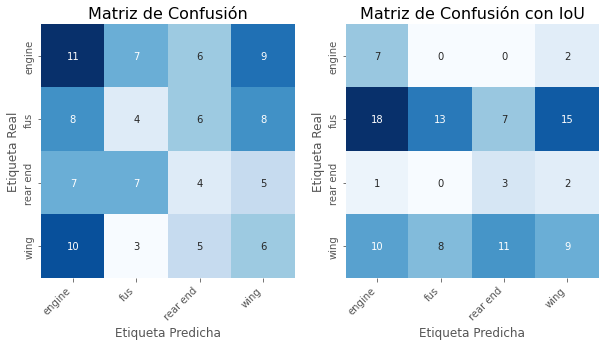

In [ ]:
y_real_new = df_iou_max["class label_true"].tolist()

y_pred_new = df_iou_max["class label_pred"].tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_heatmap(y_real, y_pred, lb.classes_, ax1, "Matriz de Confusión")
plot_heatmap(y_real_new, y_pred_new, lb.classes_, ax2, "Matriz de Confusión con IoU")
plotPath = os.path.sep.join([plot_path, "confu-matrix.png"])
plt.savefig(plotPath)

## Reporte de clasificación

In [ ]:
print(classification_report(y_real_new, y_pred_new, digits = 3))

              precision    recall  f1-score   support

      engine      0.194     0.778     0.311         9
         fus      0.619     0.245     0.351        53
    rear end      0.143     0.500     0.222         6
        wing      0.321     0.237     0.273        38

    accuracy                          0.302       106
   macro avg      0.319     0.440     0.289       106
weighted avg      0.449     0.302     0.312       106



In [ ]:
print(classification_report(y_real, y_pred, digits = 3))

              precision    recall  f1-score   support

      engine      0.306     0.333     0.319        33
         fus      0.190     0.154     0.170        26
    rear end      0.190     0.174     0.182        23
        wing      0.214     0.250     0.231        24

    accuracy                          0.236       106
   macro avg      0.225     0.228     0.225       106
weighted avg      0.232     0.236     0.233       106

